# Explorative Data Analysis

Lecture Data Engineering and Analytics<br>
Eva Zangerle

In [1]:
import os
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stemgraphic
from scipy.stats import kstest, probplot, shapiro

In [2]:
# set seaborn style
sns.set_style("darkgrid")

In [3]:
# set data directory
data_dir = "../data"

In [4]:
%load_ext watermark
%watermark -a "Eva Zangerle" --updated --date --time --iversions --githash

Author: Eva Zangerle

Last updated: 2024-10-29 07:49:30

Git hash: aa59f6bbf6f5af03d95fa9559de2beeb0d61975c

seaborn    : 0.13.2
IPython    : 8.27.0
numpy      : 2.1.1
matplotlib : 3.9.2
scipy      : 1.14.1
stemgraphic: 0.9.1
pandas     : 2.2.3



In [5]:
# show all outputs
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# set display options for pandas dataframes
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)

The following examples make use of the hetrec2011-movielens-2k dataset (https://grouplens.org/datasets/hetrec-2011/). This dataset is based on the [MovieLens 10m dataset](https://grouplens.org/datasets/movielens/10m/) and extends it with further metadata from imdb on movies and movie reviews from rottentomatoe. Find the dataset's readme [here](https://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt).

In [7]:
# read in genre data
genres = pd.read_csv(
    os.path.join(data_dir, "hetrec/movie_genres.dat"),
    delimiter="\t",
    index_col="movieID",
)
genres.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 20809 entries, 1 to 65133
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genre   20809 non-null  object
dtypes: object(1)
memory usage: 1.3 MB


In [8]:
# read in rating data
ratings = pd.read_csv(
    os.path.join(data_dir, "hetrec/user_ratedmovies.dat"), delimiter="\t"
)
ratings.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855598 entries, 0 to 855597
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userID       855598 non-null  int64  
 1   movieID      855598 non-null  int64  
 2   rating       855598 non-null  float64
 3   date_day     855598 non-null  int64  
 4   date_month   855598 non-null  int64  
 5   date_year    855598 non-null  int64  
 6   date_hour    855598 non-null  int64  
 7   date_minute  855598 non-null  int64  
 8   date_second  855598 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 58.7 MB


In [9]:
# read in movie data, prefix rt = rottenTomatoes
# only works when specifying encoding correctly (fails due to ~n)
movies = pd.read_csv(
    os.path.join(data_dir, "hetrec/movies.dat"),
    delimiter="\t",
    na_values=["\\N"],
    encoding="latin1",
)
movies.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10197 entries, 0 to 10196
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10197 non-null  int64  
 1   title                   10197 non-null  object 
 2   imdbID                  10197 non-null  int64  
 3   spanishTitle            10197 non-null  object 
 4   imdbPictureURL          10016 non-null  object 
 5   year                    10197 non-null  int64  
 6   rtID                    9886 non-null   object 
 7   rtAllCriticsRating      9967 non-null   float64
 8   rtAllCriticsNumReviews  9967 non-null   float64
 9   rtAllCriticsNumFresh    9967 non-null   float64
 10  rtAllCriticsNumRotten   9967 non-null   float64
 11  rtAllCriticsScore       9967 non-null   float64
 12  rtTopCriticsRating      9967 non-null   float64
 13  rtTopCriticsNumReviews  9967 non-null   float64
 14  rtTopCriticsNumFresh    9967 non-null 

## Univariate Non-Graphical EDA

In the following, we will perform non-graphical exploratory data analysis as a first step towards getting a deeper understanding of the characteristics of the dataset. Particularly, we will start with the genre data.

### Basics

In [10]:
# simple exploration
genres.head()
len(genres)

,genre
movieID,
1,Adventure
1,Animation
1,Children
1,Comedy
1,Fantasy


20809

In [11]:
# which genres are contained?
genres["genre"].unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Film-Noir', 'Western', 'Short'], dtype=object)

### Tabulation for Categorical Data

In a first step, we will use tabulation to investigate the distribution of genres across movies.

In [12]:
# combine counts and relative frequency in a dataframe to prettify output
pd.DataFrame(
    {
        "count": genres["genre"].value_counts(),
        "share": genres["genre"].value_counts(normalize=True),
    }
)

,count,share
genre,,
Drama,5076,0.243933
Comedy,3566,0.171368
Thriller,1664,0.079965
Romance,1644,0.079004
Action,1445,0.069441
Crime,1086,0.052189
Adventure,1003,0.048200
Horror,978,0.046999
Sci-Fi,740,0.035562


### Location

In a next step, we will also include the ratings data in our evaluation and investigate the rating behavior of users for movies.

In [13]:
# look at raw data
ratings["rating"].head()
ratings["rating"].tail()
ratings.sample(n=10, random_state=3)

0    1.0
1    4.5
2    4.0
3    2.0
4    4.0
Name: rating, dtype: float64

855593    4.0
855594    4.0
855595    4.5
855596    5.0
855597    4.5
Name: rating, dtype: float64

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
618259,50670,517,4.0,1,6,2001,21,49,46
122393,10132,60753,4.0,23,8,2008,17,5,45
653376,52834,147,3.0,13,12,1999,17,40,45
147297,12296,1094,4.0,27,5,1998,15,19,49
156557,13029,6281,5.0,27,1,2006,23,37,41
3949,533,3196,4.5,22,6,2003,8,10,16
24877,2471,1704,3.0,15,7,2008,9,40,36
25245,2513,1653,4.5,8,7,2007,21,46,6
638844,51901,4571,3.5,1,11,2005,11,45,7
209532,17999,249,3.0,3,6,2004,19,44,48


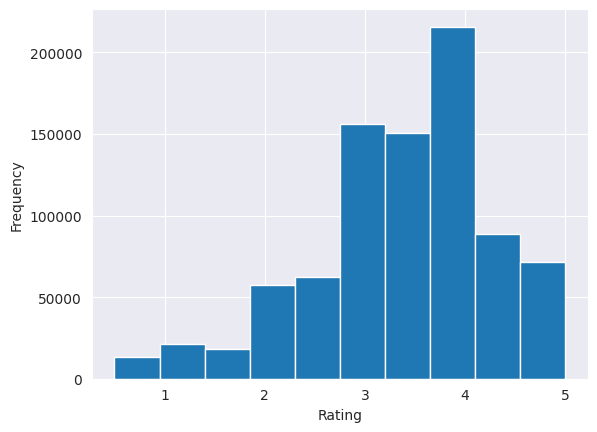

In [14]:
#  rating distribution across all movies
plt.hist(ratings["rating"], bins=10)
plt.xlabel("Rating")
plt.ylabel("Frequency");

In [15]:
# inspect location
# mean
ratings["rating"].mean()
# median
ratings["rating"].median()
# mode
ratings["rating"].mode()

np.float64(3.437945156487042)

np.float64(3.5)

0    4.0
Name: rating, dtype: float64

The following examples showcase the role of location for a normal, hence, symmetric distribution and a highly skewed distribution.

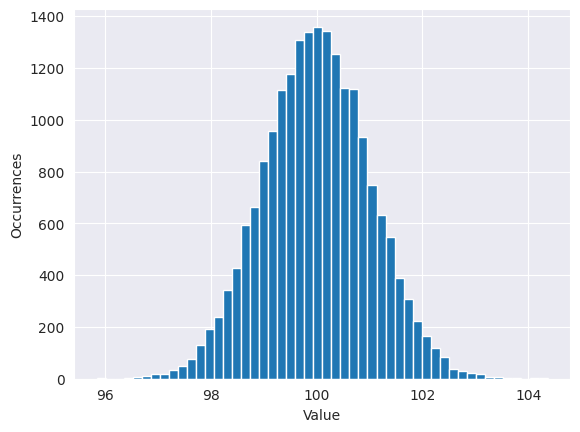

In [16]:
# create a symmetricly distributed dataset
normal_distribution = pd.Series(np.random.randn(20000) + 100)
plt.hist(normal_distribution, bins=50)
plt.xlabel("Value")
plt.ylabel("Occurrences");

In [17]:
# location
normal_distribution.mean()
normal_distribution.median()

np.float64(99.99848891926256)

np.float64(99.99951071777616)

In [18]:
# asymmetric, skewed distribution
# number of ratings per movie
rating_counts = ratings.groupby("movieID")["rating"].agg("count")
rating_counts.sort_values()
rating_counts[rating_counts == 1]

movieID
730         1
33191       1
64993       1
64986       1
67          1
         ... 
5952     1528
296      1537
356      1568
4993     1576
2571     1670
Name: rating, Length: 10109, dtype: int64

movieID
67       1
134      1
139      1
143      1
226      1
        ..
65006    1
65011    1
65088    1
65091    1
65130    1
Name: rating, Length: 602, dtype: int64

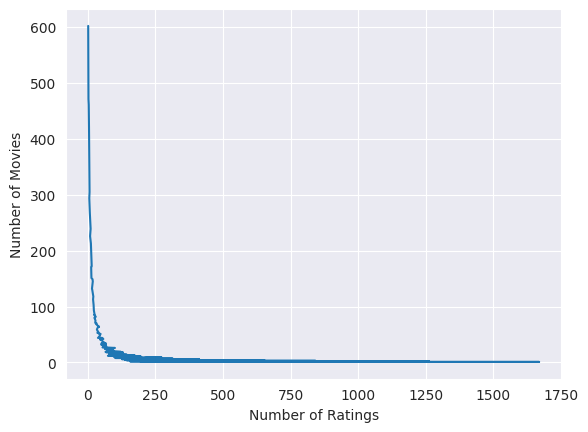

In [19]:
# plot number of movies with given number of ratings
plt.plot(rating_counts.value_counts())
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies");

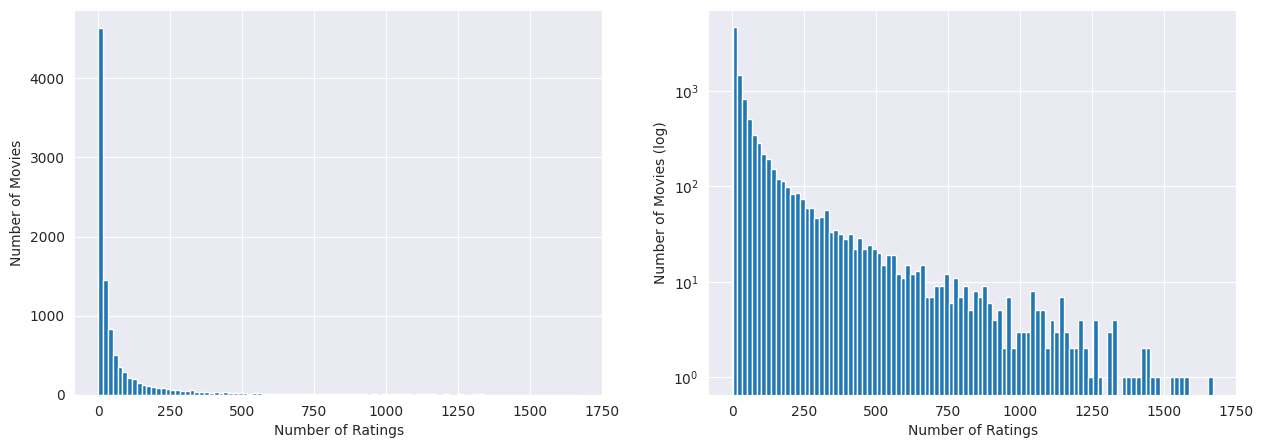

In [20]:
# histogram of number of movies with given number of ratings
# (binned value counts)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(rating_counts, bins=100)
axes[0].set_ylabel("Number of Movies")
axes[0].set_xlabel("Number of Ratings")
axes[1].hist(rating_counts, log=True, bins=100)
axes[1].set_ylabel("Number of Movies (log)")
axes[1].set_xlabel("Number of Ratings");

In [21]:
# mean and median number of ratings
rating_counts.mean()
rating_counts.median()
rating_counts.describe()

np.float64(84.63725393213967)

np.float64(21.0)

count    10109.000000
mean        84.637254
std        172.115584
min          1.000000
25%          6.000000
50%         21.000000
75%         75.000000
max       1670.000000
Name: rating, dtype: float64

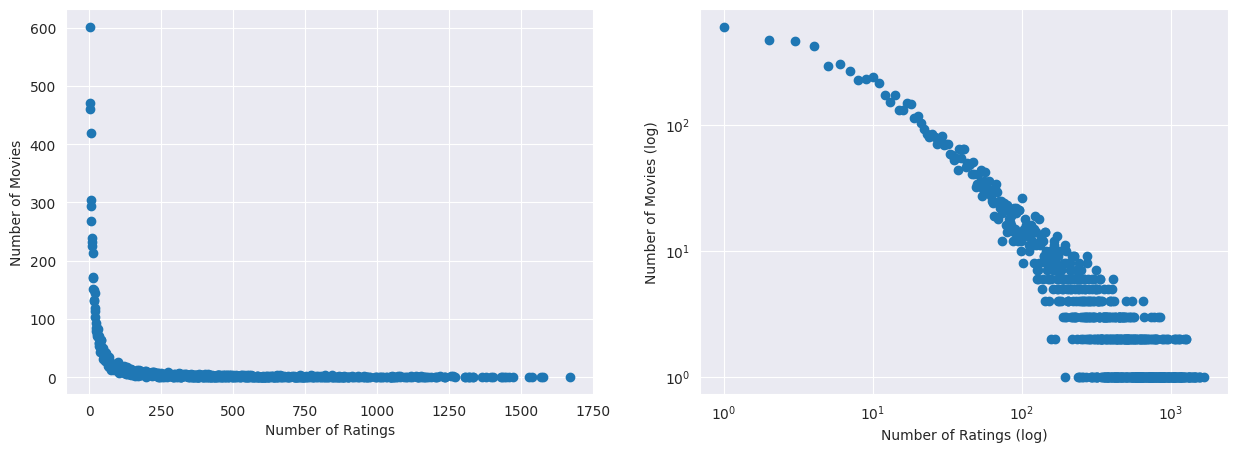

In [22]:
# slightly different way of getting overview of ratings per movie
# plot distribution of binned count values
count_histogram = rating_counts.value_counts()
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(count_histogram.index, count_histogram)
axes[0].set_xlabel("Number of Ratings")
axes[0].set_ylabel("Number of Movies")
axes[1].scatter(count_histogram.index, count_histogram)
axes[1].set_xlabel("Number of Ratings (log)")
axes[1].set_ylabel("Number of Movies (log)")
axes[1].set_xscale("log")
axes[1].set_yscale("log");

In [23]:
# use describe function for summary of ratings generally
ratings["rating"].describe()

count    855598.000000
mean          3.437945
std           1.002561
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

### Spread

The following examples show measure of spread for our ratings example.

In [24]:
ratings["rating"].std()
ratings["rating"].var()

np.float64(1.002560872161038)

np.float64(1.005128302388301)

In [25]:
# IQR
ratings["rating"].quantile(0.75) - ratings["rating"].quantile(0.25)
ratings["rating"].describe()

np.float64(1.0)

count    855598.000000
mean          3.437945
std           1.002561
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Short detour: how does sample size impact how representative the sample is for the full population.

In [26]:
# sampling effect (for n=10 vs. n=1000, for instance)
sample_ratings = ratings.sample(n=10, random_state=5)
sample_ratings["rating"].std()
sample_ratings["rating"].var()

np.float64(0.6666666666666666)

np.float64(0.4444444444444444)

In [27]:
# look at all samples that have a rating within mean +/- 1 std
sample_ratings = ratings.sample(n=1000, random_state=5)
sample_ratings[
    (
        sample_ratings["rating"]
        > (sample_ratings["rating"].mean() - sample_ratings["rating"].std())
    )
    & (
        sample_ratings["rating"]
        < (sample_ratings["rating"].mean() + sample_ratings["rating"].std())
    )
]

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
97121,8127,7254,3.0,4,12,2006,13,57,17
854304,71509,3060,3.5,30,8,2004,16,50,29
320729,26116,8933,4.0,12,10,2004,1,14,41
75021,6757,2692,3.0,5,7,2002,9,26,34
772382,64621,3654,4.0,20,10,2001,5,39,11
...,...,...,...,...,...,...,...,...,...
469043,37419,588,4.0,11,8,2007,9,11,8
541266,43527,8873,4.0,2,9,2006,17,33,58
768444,64472,1438,2.5,27,5,2003,22,46,53
519540,41201,101,3.5,1,11,2008,0,0,17


In [28]:
len(ratings)

855598

Side note - for normal distributions:  
68% of all observations fall within +/- 1 standard deviation  
95% of all observations fall within +/- 2 standard deviations  
99.7% of all observations fall within +/- 3 standard deviations

In [29]:
# use shapiro-wilk test to test for normal distribution (usually quite suited
# for smaller samples)
# here, non-normal distribution is already clear from the histogram
# output of shapiro-wilk: test statistics, p-value
# null hypothesis: distribution was drawn from normally distributed data
statistics, p = shapiro(sample_ratings["rating"])
statistics, p

(np.float64(0.9314985145962038), np.float64(5.4982382275609096e-21))

In [30]:
# Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(sample_ratings["rating"], "norm")
ks_statistic, p_value

(np.float64(0.9092498680518208), np.float64(0.0))

### Shape

The following examples showcase shape measures for the given dataset.

In [31]:
# skewness and kurtosis of ratings
ratings["rating"].skew()
ratings["rating"].kurtosis()

np.float64(-0.7009990282814003)

np.float64(0.33623508094406773)

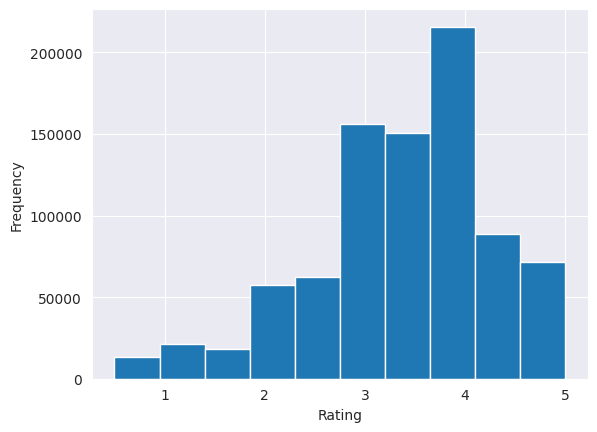

In [32]:
plt.hist(ratings["rating"])
plt.xlabel("Rating")
plt.ylabel("Frequency");

In [33]:
# skewness and kurtosis of rating counts
rating_counts.skew()
rating_counts.kurtosis()

np.float64(3.981817617200359)

np.float64(19.488816492218888)

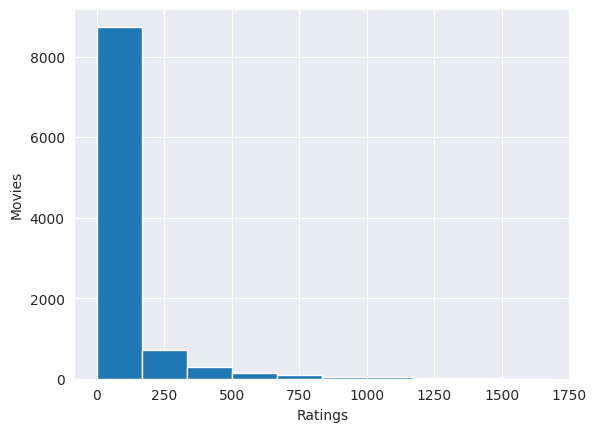

In [34]:
plt.hist(rating_counts)
plt.xlabel("Ratings")
plt.ylabel("Movies");

In [35]:
# in comparison: skew and kurtosis of normally distributed values
normal_distribution.skew()
normal_distribution.kurtosis()

np.float64(0.016531161602998754)

np.float64(0.024887901580532112)

## Univariate Graphical EDA

Even though we have already seen a number of charts in the previous section (mostly to support the explanation of the non-graphical EDA elements), we now focus on graphical EDA.

### Boxplots

The following examples showcase boxplots for different distributions.

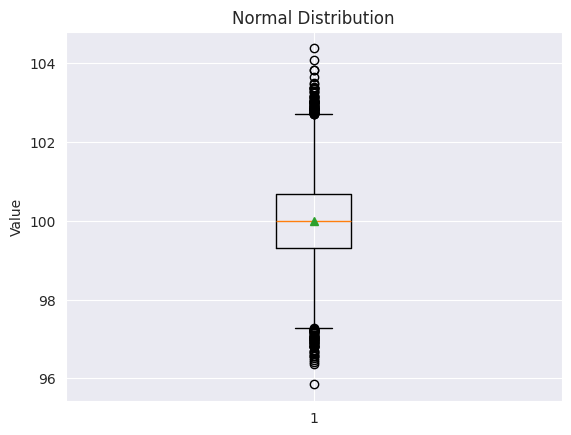

In [36]:
# normally distributed data
plt.boxplot(normal_distribution, showmeans=True)
plt.title("Normal Distribution")
plt.ylabel("Value");

In [37]:
# average rating per movie
rating_mean = ratings.groupby("movieID")["rating"].agg("mean")
rating_mean.describe()

count    10109.000000
mean         3.213406
std          0.640538
min          0.500000
25%          2.851293
50%          3.312415
75%          3.681452
max          5.000000
Name: rating, dtype: float64

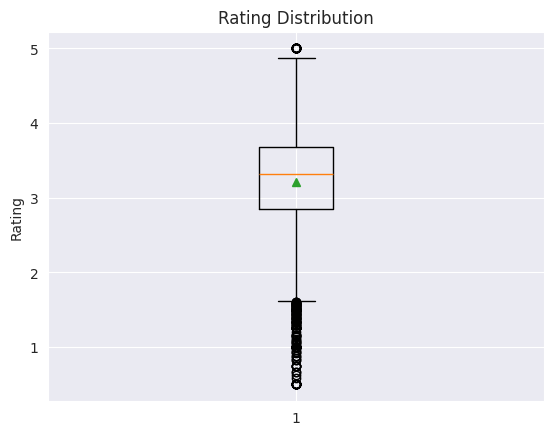

In [38]:
# somewhat symmetrical distribution
plt.boxplot(rating_mean, showmeans=True)
plt.ylabel("Rating")
plt.title("Rating Distribution");

For skewed distributions (long tails), the boxplot also (naturally) is skewed. The box (including median) and whiskers are not symmetrical. Considering value higher than Q3+1.5QR is shown as an outlier.

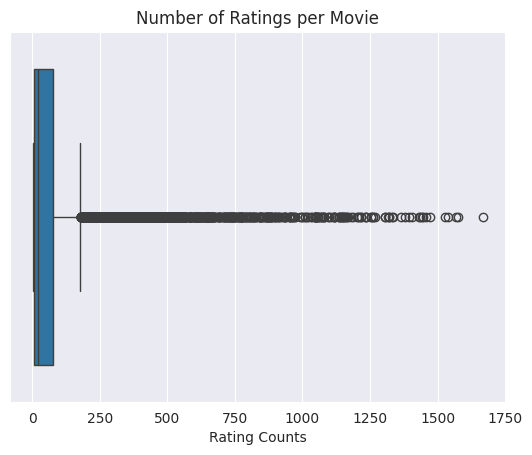

In [39]:
# skewed, long tail distribution example
sns.boxplot(x=rating_counts)
plt.xlabel("Rating Counts")
plt.title("Number of Ratings per Movie");

### Bar Charts

<Axes: xlabel='Genre', ylabel='Movie Count'>

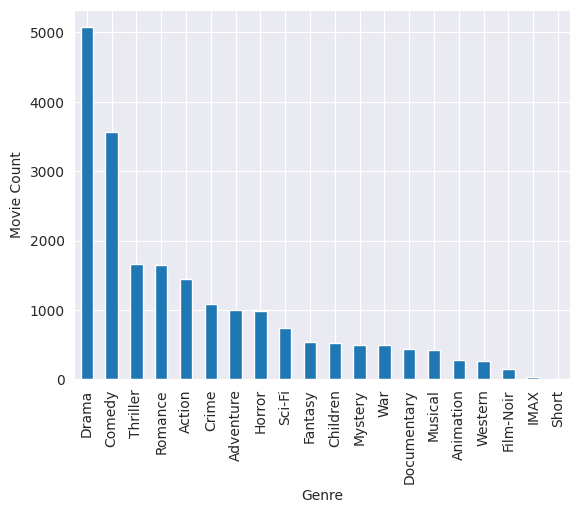

In [40]:
genres["genre"].value_counts().plot.bar(xlabel="Genre", ylabel='Movie Count')

### Histograms

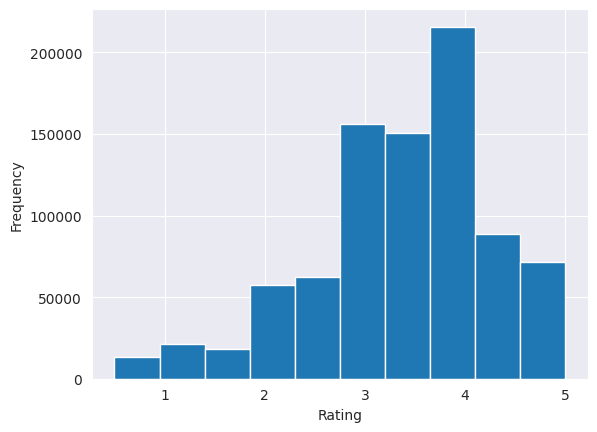

In [41]:
# rating distribution
plt.hist(ratings["rating"])
plt.xlabel("Rating")
plt.ylabel("Frequency");

In the following, we will investigate different numbers of bins for the same dataset.

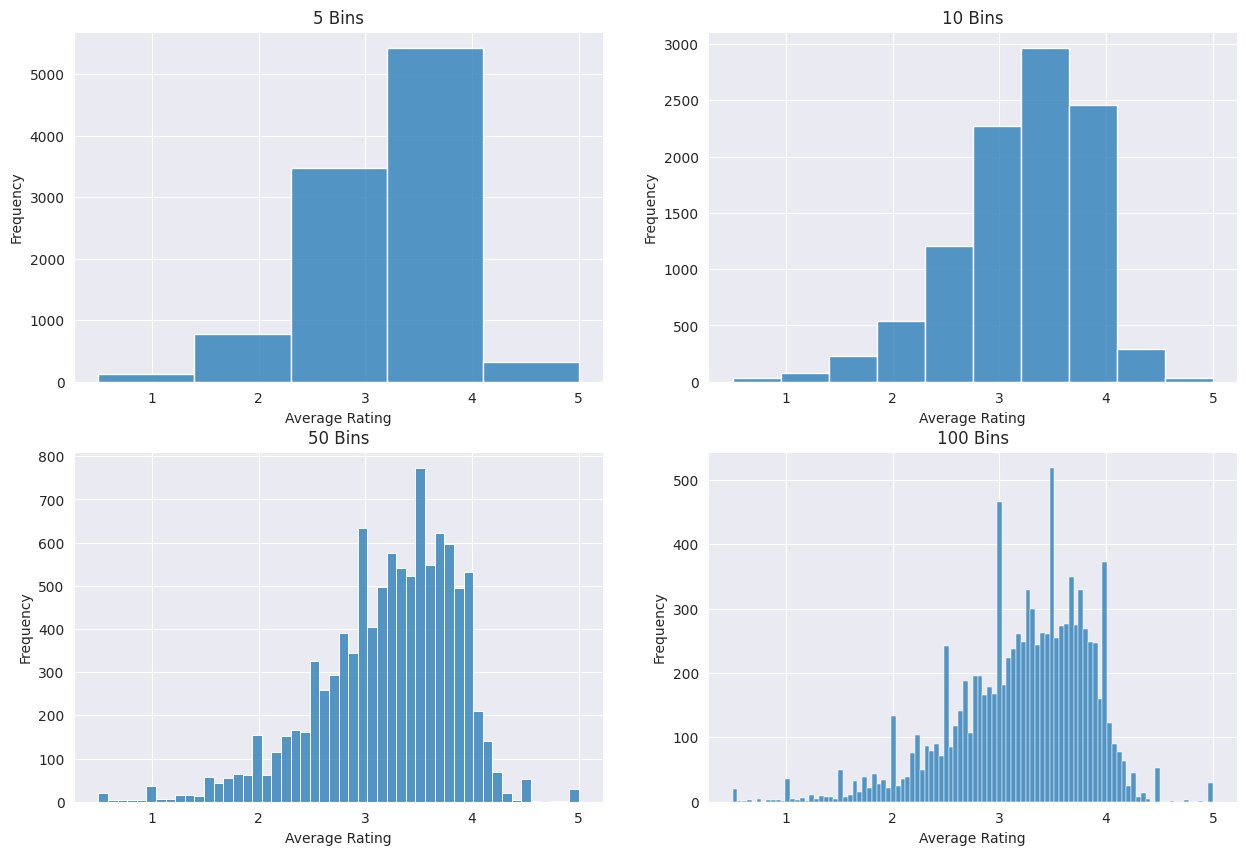

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(rating_mean, ax=axes[0, 0], bins=5)
axes[0, 0].set_title("5 Bins")
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_ylabel("Frequency")

sns.histplot(rating_mean, ax=axes[0, 1], bins=10)
axes[0, 1].set_title("10 Bins")
axes[0, 1].set_xlabel("Average Rating")
axes[0, 1].set_ylabel("Frequency")

sns.histplot(rating_mean, ax=axes[1, 0], bins=50)
axes[1, 0].set_title("50 Bins")
axes[1, 0].set_xlabel("Average Rating")
axes[1, 0].set_ylabel("Frequency")

sns.histplot(rating_mean, ax=axes[1, 1], bins=100)
axes[1, 1].set_title("100 Bins")
axes[1, 1].set_xlabel("Average Rating")
axes[1, 1].set_ylabel("Frequency");

### Density Plots

Closely related to histograms are density plots (Kernel Density Estimation). 

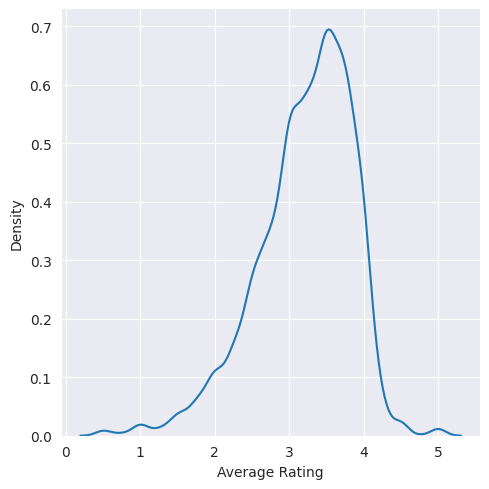

In [43]:
# kde plot of average rating per movie (default parameters)
sns.displot(rating_mean, kind="kde")
plt.xlabel("Average Rating")
plt.ylabel("Density");

In the following, we will investigate different settings for the bandwidth parameter and its impact on the smoothness of the density function.

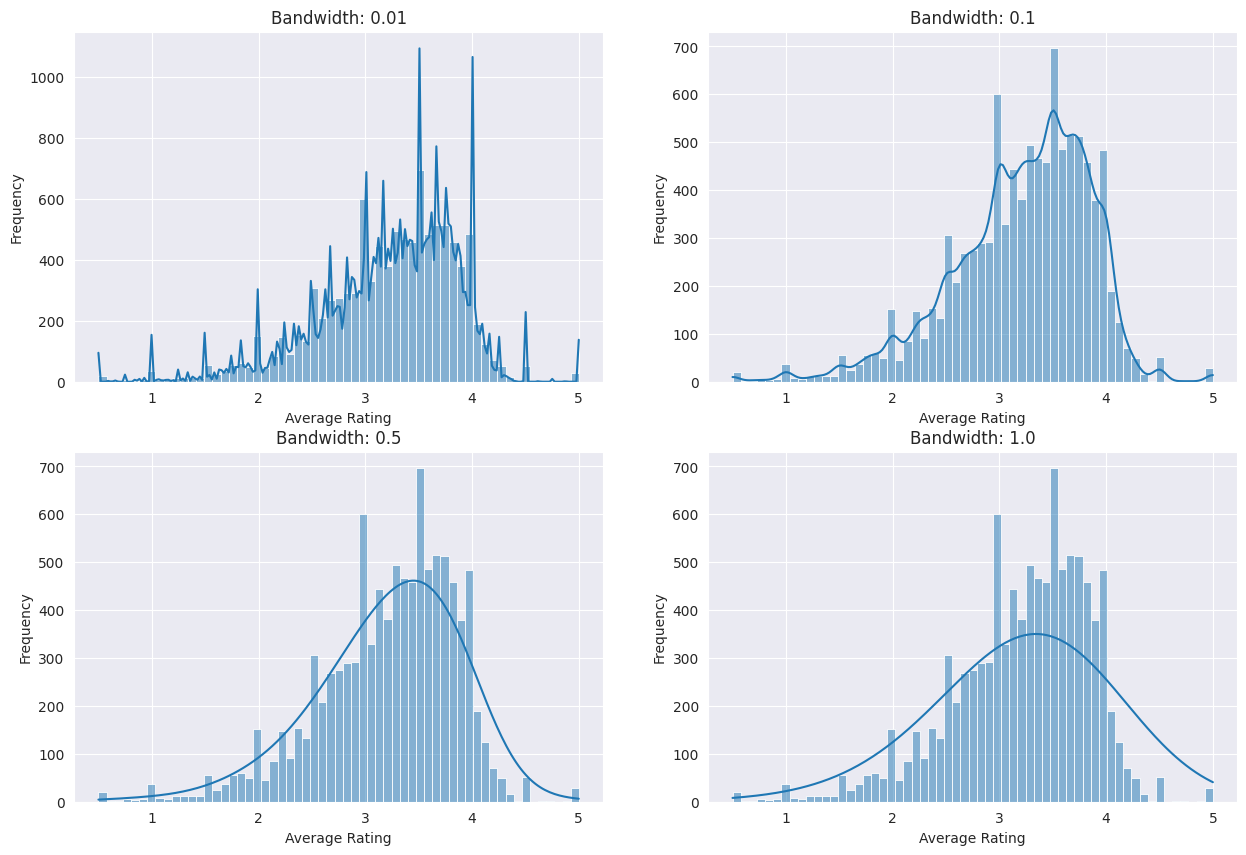

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(rating_mean, kde_kws={"bw_method": 0.01}, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Bandwidth: 0.01")
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_ylabel("Frequency")


sns.histplot(rating_mean, kde_kws={"bw_method": 0.1}, ax=axes[0, 1], kde=True)
axes[0, 1].set_title("Bandwidth: 0.1")
axes[0, 1].set_xlabel("Average Rating")
axes[0, 1].set_ylabel("Frequency")

sns.histplot(rating_mean, kde_kws={"bw_method": 0.5}, ax=axes[1, 0], kde=True)
axes[1, 0].set_title("Bandwidth: 0.5")
axes[1, 0].set_xlabel("Average Rating")
axes[1, 0].set_ylabel("Frequency")

sns.histplot(rating_mean, kde_kws={"bw_method": 1.0}, ax=axes[1, 1], kde=True)
axes[1, 1].set_title("Bandwidth: 1.0")
axes[1, 1].set_xlabel("Average Rating")
axes[1, 1].set_ylabel("Frequency");

### Stem and Leaf Plot

Stem plots can be considered a very basic histogram, where the stem captures the first number (or, hundreds, thousands, etc) of the number and the leaf shows the remainder of the number for each value; hence, forming a basic histogram.

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
618259,50670,517,4.0,1,6,2001,21,49,46
122393,10132,60753,4.0,23,8,2008,17,5,45
653376,52834,147,3.0,13,12,1999,17,40,45
147297,12296,1094,4.0,27,5,1998,15,19,49
156557,13029,6281,5.0,27,1,2006,23,37,41
3949,533,3196,4.5,22,6,2003,8,10,16
24877,2471,1704,3.0,15,7,2008,9,40,36
25245,2513,1653,4.5,8,7,2007,21,46,6
638844,51901,4571,3.5,1,11,2005,11,45,7
209532,17999,249,3.0,3,6,2004,19,44,48


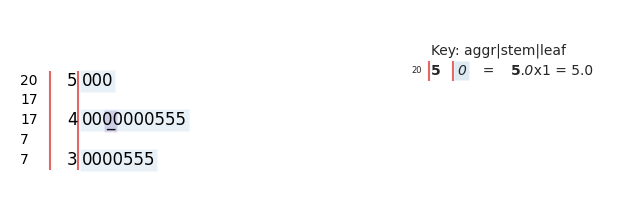

In [45]:
stem_ratings = ratings.sample(n=20, random_state=3)
stem_ratings
fig, ax = stemgraphic.stem_graphic(stem_ratings["rating"])

### Violin plots

Violin plots combine boxplots and density plots. The shape of the box describes the density function, the thin bar in the box describes [Q1-1.5 IQR, Q3+1.5 IQR] (essentially the whiskers), the thick bar describes the box (IQR) and the white dot describes the median of the distribution.

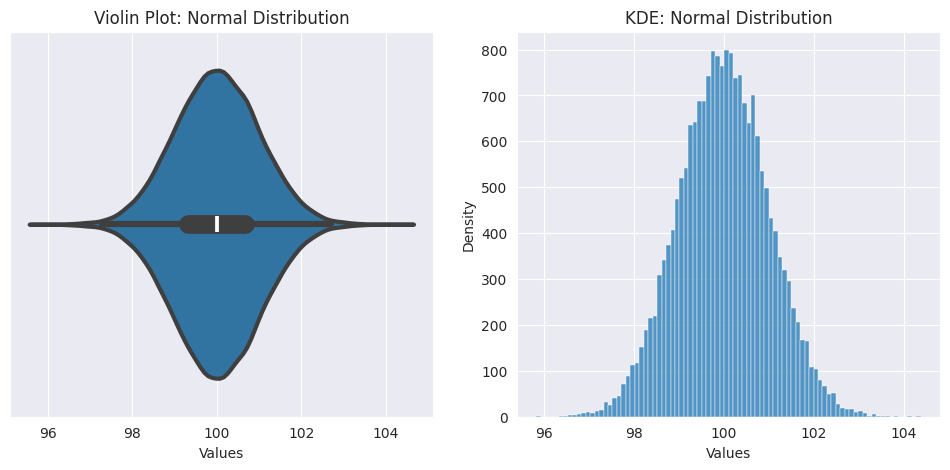

In [46]:
# violin and kde for rating counts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(x=normal_distribution, ax=axes[0], linewidth=3)
axes[0].set_xlabel("Values")
axes[0].set_title("Violin Plot: Normal Distribution")

sns.histplot(normal_distribution, ax=axes[1])
axes[1].set_title("KDE: Normal Distribution")
axes[1].set_xlabel("Values")
axes[1].set_ylabel("Density");

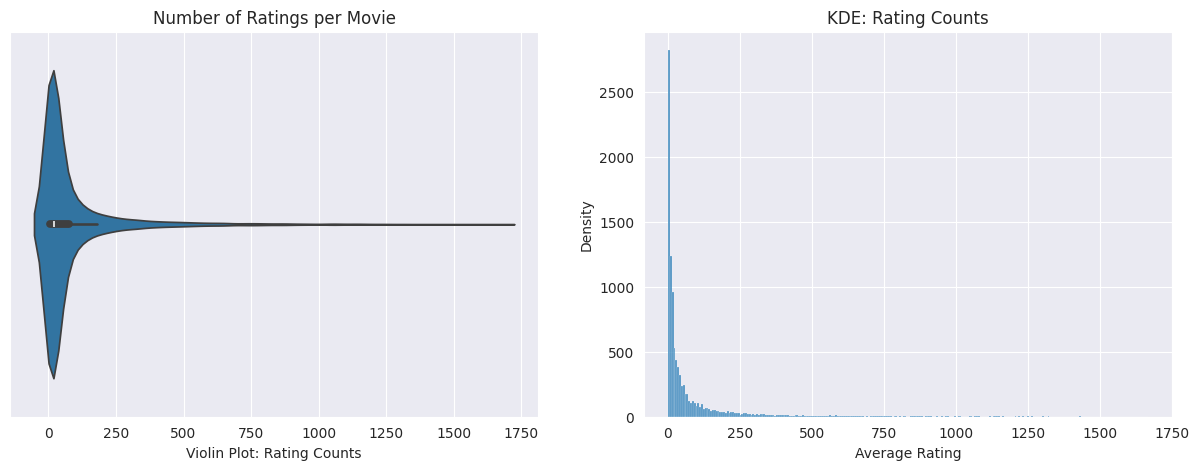

In [47]:
# violin and kde for rating counts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.violinplot(x=rating_counts, ax=axes[0])
axes[0].set_xlabel("Violin Plot: Rating Counts")
axes[0].set_title("Number of Ratings per Movie")

sns.histplot(rating_counts, ax=axes[1])
axes[1].set_title("KDE: Rating Counts")
axes[1].set_xlabel("Average Rating")
axes[1].set_ylabel("Density");

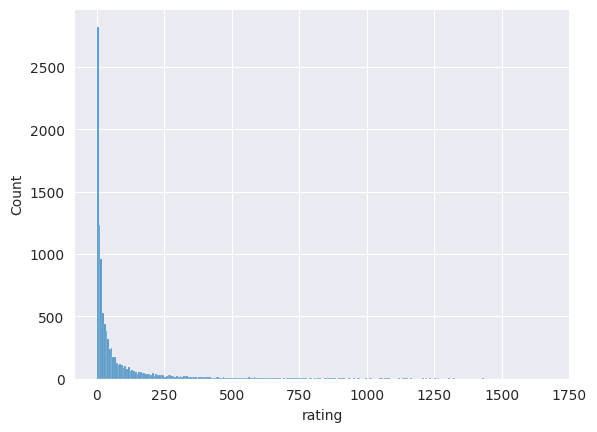

In [48]:
sns.histplot(x=rating_counts);

### Quantile-Normal Plots

Quantile-quantile plots aim to compare two distributions by comparing their quantiles (i.e., we plot their quantiles against each other). Often, one of the distributions is a normal distributions to check whether the other distribution is also normally distributed. 

The `probplot` function (from `scipy.stats`) generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default).

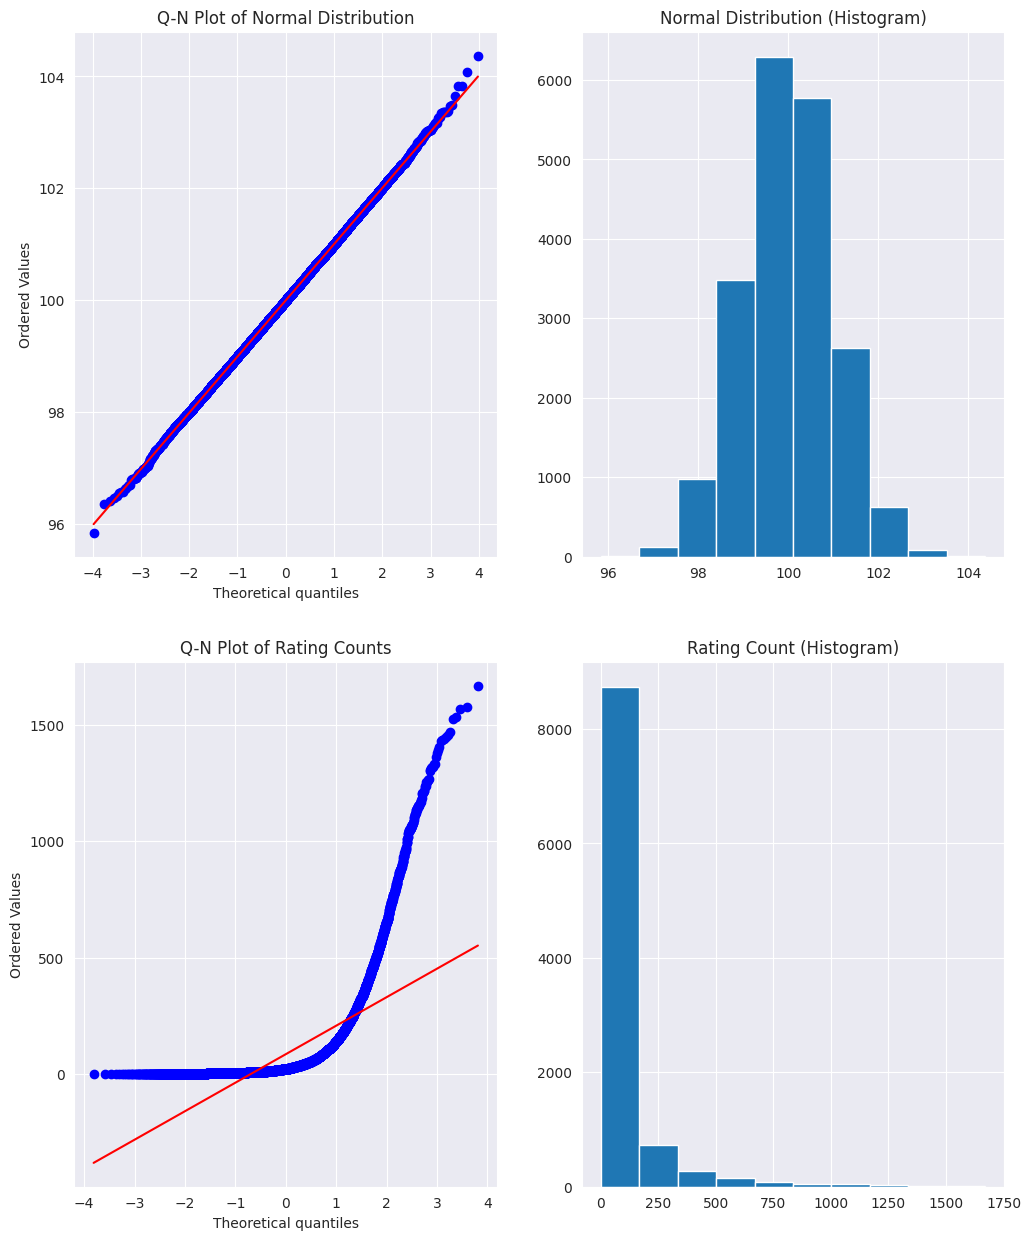

In [49]:
# no distribution given -> use normal distribution with same mean and
fig, axes = plt.subplots(2, 2, figsize=(12, 15))
probplot(normal_distribution, plot=axes[0, 0])
axes[0, 0].set_title("Q-N Plot of Normal Distribution")
axes[0, 1].hist(normal_distribution)
axes[0, 1].set_title("Normal Distribution (Histogram)")

probplot(rating_counts, plot=axes[1, 0])
axes[1, 0].set_title("Q-N Plot of Rating Counts")
axes[1, 1].hist(rating_counts)
axes[1, 1].set_title("Rating Count (Histogram)");

In the case of rating counts, we clearly see that (i) the distribution is not normally distributed, (ii) and that the distribution is heavy tailed.

## Multivariate Non-Graphical EDA

### Cross-Tabulation

In [50]:
# data preparation
# merge ratings and genre data frames
genre_ratings = pd.merge(ratings, genres, on="movieID")
genre_ratings.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second,genre
0,75,3,1.0,29,10,2006,23,17,16,Comedy
1,75,3,1.0,29,10,2006,23,17,16,Romance
2,75,32,4.5,29,10,2006,23,23,44,Sci-Fi
3,75,32,4.5,29,10,2006,23,23,44,Thriller
4,75,110,4.0,29,10,2006,23,30,8,Action


In [51]:
# compute ratings per genre and year
genre_year_rating_counts = pd.DataFrame(
    genre_ratings.groupby(["genre", "date_year"])["rating"].agg("count")
)

In [52]:
# alternative
genre_ratings.pivot_table(
    ["rating"], index=["genre", "date_year"], aggfunc="count", margins=True
)

rating
genre   date_year         
Action  1997           200
        1998           540
        1999          3206
        2000          7349
        2001          6872
...                    ...
Western 2006          3357
        2007          2723
        2008          2424
        2009            64
All                2240215

[248 rows x 1 columns]

In [53]:
# another, visually cleaner alternative
pd.crosstab(genre_ratings.genre, genre_ratings.date_year)

date_year,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
genre,,,,,,,,,,,,,
Action,200,540,3206,7349,6872,8069,12868,22478,37289,53049,46625,42087,961
Adventure,141,437,2390,5689,4906,5792,9746,16581,27022,40023,34476,31521,702
Animation,31,93,587,1312,1067,1505,2549,3871,6726,10872,8839,8704,195
Children,56,218,936,2411,1809,2470,4264,6150,10073,15200,11619,10798,281
Comedy,247,767,4512,12458,10428,13223,23018,33914,49961,72448,58235,52867,1271
Crime,98,292,1742,3913,3676,4361,7784,12173,19416,29321,25559,23919,513
Documentary,3,18,124,291,185,290,679,1368,2016,3080,2633,2287,24
Drama,328,971,5945,14897,11706,14168,24326,36247,55398,80793,72064,65850,1338
Fantasy,46,182,1165,2780,2240,3001,5081,8456,13801,21843,20140,17313,374


### Univariate Statistics per Category

In [54]:
# rating behavior per genre
genre_ratings.groupby("genre")["rating"].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,241593.0,3.338652,1.018203,0.5,3.00,3.5,4.00,5.0
Adventure,179426.0,3.401007,1.004163,0.5,3.00,3.5,4.00,5.0
Animation,46351.0,3.526450,0.963297,0.5,3.00,3.5,4.00,5.0
Children,66285.0,3.310410,1.045600,0.5,3.00,3.5,4.00,5.0
Comedy,333349.0,3.346851,1.018833,0.5,3.00,3.5,4.00,5.0
Crime,132767.0,3.601392,0.949798,0.5,3.00,4.0,4.00,5.0
Documentary,12998.0,3.706840,0.933780,0.5,3.50,4.0,4.50,5.0
Drama,384031.0,3.608434,0.926720,0.5,3.00,4.0,4.00,5.0
Fantasy,96422.0,3.435113,1.008190,0.5,3.00,3.5,4.00,5.0


### Correlation and Covariance

In [55]:
# covariance
movies["rtAllCriticsRating"].cov(movies["rtTopCriticsRating"])
movies["rtAllCriticsRating"].cov(movies["rtAudienceRating"])

np.float64(3.4613439332740064)

np.float64(2.405258841332729)

In [56]:
# covariance pairwise between multiple variables
movies[["rtAllCriticsRating", "rtAudienceRating", "rtTopCriticsRating"]].cov()

,rtAllCriticsRating,rtAudienceRating,rtTopCriticsRating
rtAllCriticsRating,6.749855,2.405259,3.461344
rtAudienceRating,2.405259,2.379055,2.565817
rtTopCriticsRating,3.461344,2.565817,9.857172


In [57]:
# correlation coefficient
movies["rtAudienceRating"].corr(movies["rtAllCriticsRating"])

np.float64(0.6002225747671531)

We can also look into the pairwise correlation between multiple variables, displayed as a correlation matrix.

In [58]:
# correlation coefficient pairwise between multiple variables
movies[["rtAllCriticsRating", "rtAudienceRating", "rtTopCriticsRating"]].corr()

,rtAllCriticsRating,rtAudienceRating,rtTopCriticsRating
rtAllCriticsRating,1.000000,0.600223,0.424347
rtAudienceRating,0.600223,1.000000,0.529843
rtTopCriticsRating,0.424347,0.529843,1.000000


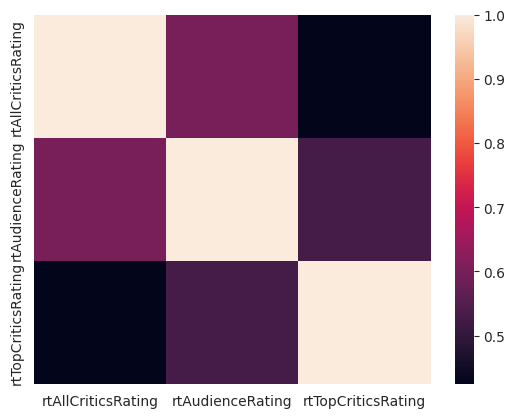

In [59]:
# visualize correlation matrix as heatmap
sns.heatmap(
    movies[
        ["rtAllCriticsRating", "rtAudienceRating", "rtTopCriticsRating"]
    ].corr()
);

## Multivariate Graphical EDA

### Univariate Graph per Category

Performing multivariate, graphical EDA often simply means that we look at univariate distributions for multiple categories.

/tmp/ipykernel_19728/2942530919.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



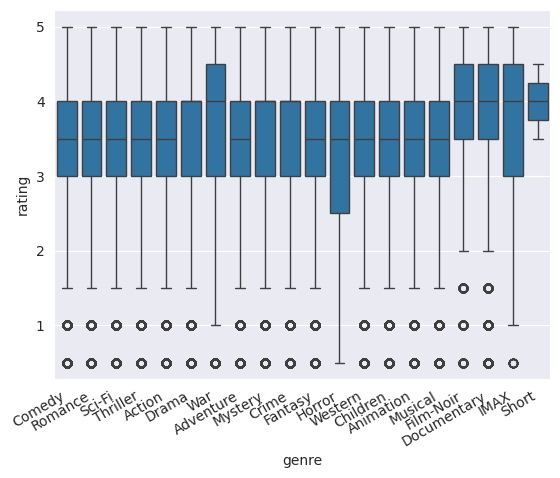

In [60]:
# boxplot with rating distribution per genre
ax = sns.boxplot(x="genre", y="rating", data=genre_ratings)
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
ax.set_xticklabels(labels, fontsize=10, rotation=30, ha="right");

### Scatterplots

In [61]:
# look at dataframe again
movies

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),"http://ia.media-imdb.com/images/M/MV5BMTMwNDU0NTY2Nl5BMl5BanBnXkFtZTcwOTUxOTM5Mw@@._V1._SX214_CR0,0,214,314_.jpg",1995,toy_story,9.0,73.0,73.0,0.0,100.0,8.5,17.0,17.0,0.0,100.0,3.7,102338.0,81.0,http://content7.flixster.com/movie/10/93/63/10936393_det.jpg
1,2,Jumanji,113497,Jumanji,"http://ia.media-imdb.com/images/M/MV5BMzM5NjE1OTMxNV5BMl5BanBnXkFtZTcwNDY2MzEzMQ@@._V1._SY314_CR3,0,214,314_.jpg",1995,1068044-jumanji,5.6,28.0,13.0,15.0,46.0,5.8,5.0,2.0,3.0,40.0,3.2,44587.0,61.0,http://content8.flixster.com/movie/56/79/73/5679734_det.jpg
2,3,Grumpy Old Men,107050,Dos viejos gruñones,"http://ia.media-imdb.com/images/M/MV5BMTI5MTgyMzE0OF5BMl5BanBnXkFtZTYwNzAyNjg5._V1._SX214_CR0,0,214,314_.jpg",1993,grumpy_old_men,5.9,36.0,24.0,12.0,66.0,7.0,6.0,5.0,1.0,83.0,3.2,10489.0,66.0,http://content6.flixster.com/movie/25/60/256020_det.jpg
3,4,Waiting to Exhale,114885,Esperando un respiro,"http://ia.media-imdb.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1._SY314_CR4,0,214,314_.jpg",1995,waiting_to_exhale,5.6,25.0,14.0,11.0,56.0,5.5,11.0,5.0,6.0,45.0,3.3,5666.0,79.0,http://content9.flixster.com/movie/10/94/17/10941715_det.jpg
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abuelo),"http://ia.media-imdb.com/images/M/MV5BMTg1NDc2MjExOF5BMl5BanBnXkFtZTcwNjU1NDAzMQ@@._V1._SY314_CR5,0,214,314_.jpg",1995,father_of_the_bride_part_ii,5.3,19.0,9.0,10.0,47.0,5.4,5.0,1.0,4.0,20.0,3.0,13761.0,64.0,http://content8.flixster.com/movie/25/54/255426_det.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,65088,Bedtime Stories,960731,Más allá de los sueños,"http://ia.media-imdb.com/images/M/MV5BMjA5Njk5MTUxNF5BMl5BanBnXkFtZTcwMDI3MTg5MQ@@._V1._SX214_CR0,0,214,314_.jpg",2008,bedtime_stories,4.4,104.0,26.0,78.0,25.0,4.7,26.0,6.0,20.0,23.0,3.5,108877.0,63.0,http://content6.flixster.com/movie/10/94/33/10943312_det.jpg
10193,65091,Manhattan Melodrama,25464,El enemigo público número 1,http://ia.media-imdb.com/images/M/MV5BMTUyODE3Nzc4Nl5BMl5BanBnXkFtZTcwMTAwMTQyMQ@@._V1._SX77_SY140_.jpg,1934,manhattan_melodrama,7.0,12.0,10.0,2.0,83.0,0.0,4.0,2.0,2.0,50.0,3.7,344.0,71.0,http://content9.flixster.com/movie/66/44/64/6644647_det.jpg
10194,65126,Choke,1024715,Choke,"http://ia.media-imdb.com/images/M/MV5BMTMxMDI4MTE0Ml5BMl5BanBnXkFtZTcwNTg0NDI3MQ@@._V1._SX214_CR0,0,214,314_.jpg",2008,choke,5.6,135.0,73.0,62.0,54.0,4.9,26.0,8.0,18.0,30.0,3.3,13893.0,55.0,http://content6.flixster.com/movie/10/85/09/10850932_det.jpg
10195,65130,Revolutionary Road,959337,Revolutionary Road,"http://ia.media-imdb.com/images/M/MV5BMTI2MzY2MDY1N15BMl5BanBnXkFtZTcwMTI1MDk5Mg@@._V1._SY314_CR4,0,214,314_.jpg",2008,revolutionary_road,6.7,194.0,133.0,61.0,68.0,6.9,36.0,25.0,11.0,69.0,3.5,46044.0,70.0,http://content8.flixster.com/movie/10/88/40/10884042_det.jpg


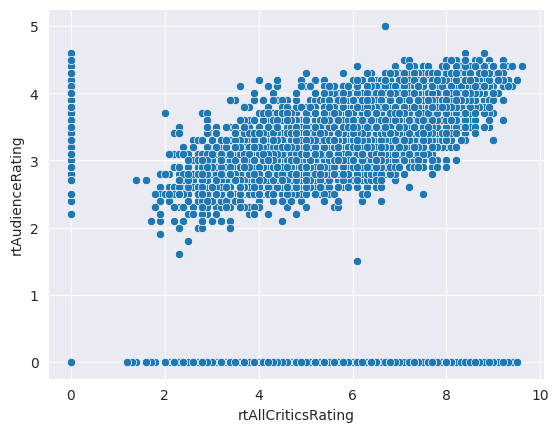

In [62]:
# investigate rtCriticsRating vs. rtAudienceRating
sns.scatterplot(x="rtAllCriticsRating", y="rtAudienceRating", data=movies);

In [63]:
# investigate 0 ratings for critics
movies.query("rtAllCriticsRating == 0")

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
31,32,Twelve Monkeys,114746,Twelve monkeys: doce monos,"http://ia.media-imdb.com/images/M/MV5BMTQwNzg2OTUzMV5BMl5BanBnXkFtZTYwMTg4ODU5._V1._SX214_CR0,0,214,314_.jpg",1995,prem-no-public-issue,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content6.flixster.com/movie/10/93/02/10930244_det.jpg
32,33,Wings of Courage,114952,Las alas del coraje,"http://ia.media-imdb.com/images/M/MV5BMTc3ODY1MjA3OF5BMl5BanBnXkFtZTcwODgzOTgyMQ@@._V1._SX214_CR0,0,214,314_.jpg",1995,NaN,0.0,4.0,2.0,2.0,50.0,0.0,2.0,1.0,1.0,50.0,0.0,0.0,0.0,http://content7.flixster.com/movie/10/97/83/10978341_det.jpg
36,37,Across the Sea of Time,112286,Across the Sea of Time,http://ia.media-imdb.com/images/M/MV5BNTQyMTE3MzY4Nl5BMl5BanBnXkFtZTcwMzY5MTAyMQ@@._V1._SX78_SY140_.jpg,1995,across_the_sea_of_time,0.0,4.0,2.0,2.0,50.0,0.0,1.0,0.0,1.0,0.0,2.9,237.0,27.0,http://content6.flixster.com/movie/10/90/58/10905808_det.jpg
38,39,Clueless,112697,Clueless: fuera de onda,"http://ia.media-imdb.com/images/M/MV5BNjQxNTA1NjE5Ml5BMl5BanBnXkFtZTYwOTMwNzE5._V1._SY314_CR3,0,214,314_.jpg",1995,school_of_senses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content8.flixster.com/movie/10/85/01/10850110_det.jpg
54,56,Kids of the Round Table,113541,Los chicos de la tabla redonda,"http://ia.media-imdb.com/images/M/MV5BMTEwMTM0MzI3OTheQTJeQWpwZ15BbWU3MDQzNTQ2MTE@._V1._SX214_CR0,0,214,314_.jpg",1997,kids-of-the-round-table,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content7.flixster.com/movie/10/85/20/10852069_det.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10186,64993,Byôsoku 5 senchimêtoru,983213,Byôsoku 5 senchimêtoru,NaN,2007,5_centimeters_per_second,0.0,2.0,2.0,0.0,100.0,0.0,1.0,1.0,0.0,100.0,4.3,1726.0,91.0,http://content7.flixster.com/movie/85/24/71/8524717_det.jpg
10188,64999,War of the Worlds 2: The Next Wave,1183733,War of the Worlds 2: The Next Wave,"http://ia.media-imdb.com/images/M/MV5BMTIyODE1NDM4Ml5BMl5BanBnXkFtZTcwNDcxMTA3MQ@@._V1._SY314_CR2,0,214,314_.jpg",2008,war_of_the_worlds_2_the_next_wave,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content6.flixster.com/movie/10/84/11/10841124_det.jpg
10189,65006,Impulse,1078899,Impulse,"http://ia.media-imdb.com/images/M/MV5BMjA5NTc0MzI1Nl5BMl5BanBnXkFtZTcwMTUwMDY4Mw@@._V1._SY314_CR3,0,214,314_.jpg",2008,impulse,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content8.flixster.com/movie/10/87/85/10878514_det.jpg
10190,65011,Zona Zamfirova,326449,Zona Zamfirova,NaN,2002,zona-zamfirova,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://images.rottentomatoescdn.com/images/defaults/poster_default.gif


In [64]:
# investigate 0 ratings for audience
movies.query("rtAudienceRating == 0")

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
31,32,Twelve Monkeys,114746,Twelve monkeys: doce monos,"http://ia.media-imdb.com/images/M/MV5BMTQwNzg2OTUzMV5BMl5BanBnXkFtZTYwMTg4ODU5._V1._SX214_CR0,0,214,314_.jpg",1995,prem-no-public-issue,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content6.flixster.com/movie/10/93/02/10930244_det.jpg
32,33,Wings of Courage,114952,Las alas del coraje,"http://ia.media-imdb.com/images/M/MV5BMTc3ODY1MjA3OF5BMl5BanBnXkFtZTcwODgzOTgyMQ@@._V1._SX214_CR0,0,214,314_.jpg",1995,NaN,0.0,4.0,2.0,2.0,50.0,0.0,2.0,1.0,1.0,50.0,0.0,0.0,0.0,http://content7.flixster.com/movie/10/97/83/10978341_det.jpg
38,39,Clueless,112697,Clueless: fuera de onda,"http://ia.media-imdb.com/images/M/MV5BNjQxNTA1NjE5Ml5BMl5BanBnXkFtZTYwOTMwNzE5._V1._SY314_CR3,0,214,314_.jpg",1995,school_of_senses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content8.flixster.com/movie/10/85/01/10850110_det.jpg
54,56,Kids of the Round Table,113541,Los chicos de la tabla redonda,"http://ia.media-imdb.com/images/M/MV5BMTEwMTM0MzI3OTheQTJeQWpwZ15BbWU3MDQzNTQ2MTE@._V1._SX214_CR0,0,214,314_.jpg",1997,kids-of-the-round-table,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content7.flixster.com/movie/10/85/20/10852069_det.jpg
57,59,Le confessionnal,112714,Le confessionnal,"http://ia.media-imdb.com/images/M/MV5BMTk2MDE1MTYyNl5BMl5BanBnXkFtZTcwMzc3NDEzMQ@@._V1._SX214_CR0,0,214,314_.jpg",1995,confessional,0.0,1.0,1.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://images.rottentomatoescdn.com/images/defaults/poster_default.gif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10182,64976,Hexed,107107,"Linda, loca y peligrosa","http://ia.media-imdb.com/images/M/MV5BMTYyNjE1MjMwOF5BMl5BanBnXkFtZTcwNTgwMDAzMQ@@._V1._SY314_CR0,0,214,314_.jpg",1993,hexed,2.0,8.0,1.0,7.0,12.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,http://content7.flixster.com/movie/10/92/33/10923349_det.jpg
10188,64999,War of the Worlds 2: The Next Wave,1183733,War of the Worlds 2: The Next Wave,"http://ia.media-imdb.com/images/M/MV5BMTIyODE1NDM4Ml5BMl5BanBnXkFtZTcwNDcxMTA3MQ@@._V1._SY314_CR2,0,214,314_.jpg",2008,war_of_the_worlds_2_the_next_wave,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content6.flixster.com/movie/10/84/11/10841124_det.jpg
10189,65006,Impulse,1078899,Impulse,"http://ia.media-imdb.com/images/M/MV5BMjA5NTc0MzI1Nl5BMl5BanBnXkFtZTcwMTUwMDY4Mw@@._V1._SY314_CR3,0,214,314_.jpg",2008,impulse,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://content8.flixster.com/movie/10/87/85/10878514_det.jpg
10190,65011,Zona Zamfirova,326449,Zona Zamfirova,NaN,2002,zona-zamfirova,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://images.rottentomatoescdn.com/images/defaults/poster_default.gif


In [72]:
# either remove movies from dataset or set 0 values to na
movies.replace({"rtAllCriticsRating": 0}, np.nan, inplace=True)
movies.replace({"rtAudienceRating": 0}, np.nan, inplace=True)
movies.replace({"rtTopCriticsRating": 0}, np.nan, inplace=True)

# removing rows with na would work as follows after the replacement
# movies = movies.dropna(how='any', axis=0)

In [66]:
# alternatively, replace via loc
movies.loc[movies["rtAllCriticsRating"] == 0, "rtAllCriticsRating"] = np.nan
movies.loc[movies["rtAudienceRating"] == 0, "rtAudienceRating"] = np.nan

<Axes: xlabel='rtAllCriticsRating', ylabel='rtAudienceRating'>

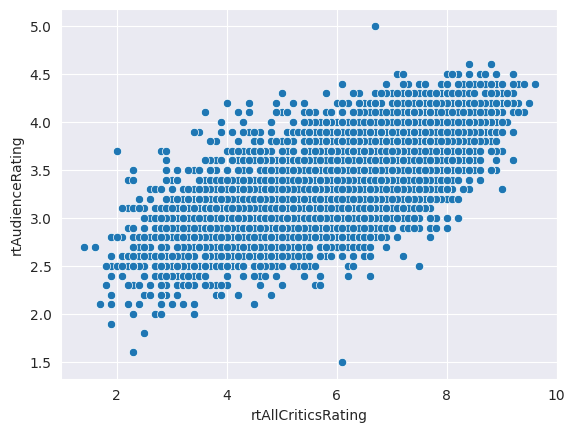

In [67]:
# resulting scatterplot
sns.scatterplot(x="rtAllCriticsRating", y="rtAudienceRating", data=movies)

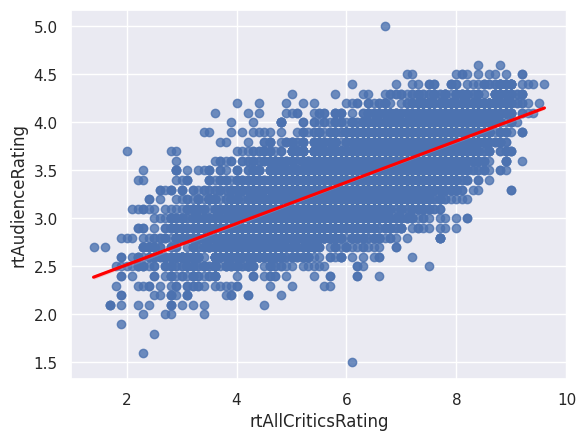

In [68]:
# fit a regression model (trend line) to this data
sns.set_theme(color_codes=True)

ax = sns.regplot(
    x="rtAllCriticsRating",
    y="rtAudienceRating",
    data=movies,
    color="b",
    line_kws={"color": "red"},
)

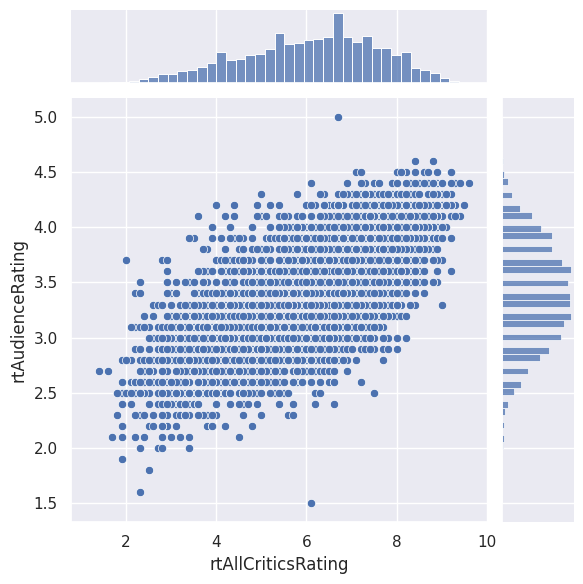

In [69]:
# use scatterplot and include distributions of individual variables: jointplot
sns.jointplot(x="rtAllCriticsRating", y="rtAudienceRating", data=movies);

In our previous examples we have focused on investigating the relationship between two variables, however, we can also investigate the (pairwise) relationships between multiple variables by using multiple scatterplots in a matrix by using Seaborns `pairplot` (or e.g., Pandas `scatter_matrix`).

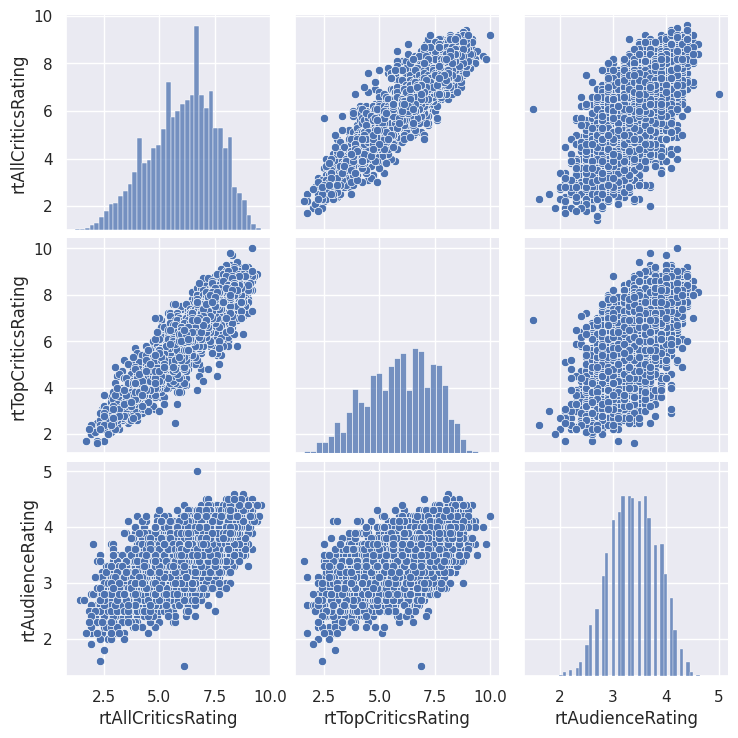

In [70]:
sns.pairplot(
    movies[["rtAllCriticsRating", "rtTopCriticsRating", "rtAudienceRating"]]
);